## Laboratorium 3 - algorytm *k* Najbliższych Sąsiadów (*k*NN)


### Opis
Celem laboratorium jest implementacja klasyfikatora *k* najbliższych sąsiadów - *k*NN (*k Nearest Neighbors*) oraz zapoznanie się z innymi metrykami klasyfikacji.


### Zbiór danych

Zbiór danych znajduje się w katalogu `dataset/*`. Jest to zmodyfikowany zbiór danych znajdujący się pod adresem: <https://archive.ics.uci.edu/ml/datasets/leaf>.

### Przesyłanie zadań

Wszystkie pliki należy spakować archiwizatorem **zip** i przesłać za pośrednictwem platformy WIKAMP. Poniżej oczekiwana zawartość archiwum:

```
+-- 📂 [IMIE.NAZWISKO].zip
    +-- 📜 Lab03.ipynb
    +-- 📂 dataset
        +-- 📜 dataset.npz
        +-- 📜 ReadMe.pdf
```

### Dodatkowe narzędzia

Dopuszczalne jest korzystanie z bibliotek: `numpy`, `pandas`, `matplotlib`.
Implementacja klasyfikatora powinna być wykonana bez wykorzystania zewnętrznych bibliotek.


### Zadanie

Należy wykonać następujące czynności w celu realizacji niniejszego zadania:
* Wczytaj dane.
* **Zaimplementuj klasyfikator *k* najbliższych sąsiadów (*k*NN)** i uruchom predykcję.
* Opisz jak zmieniają się wyniki klasyfikatora dla różnych wartości *k*, dla różnej liczby klas oraz dla różnej liczby cech.
* Wyświetl tablicę pomyłek (*confusion matrix*). W tym przypadku możesz zastosować gotową implementację z biblioteki `scikit-learn` <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html>.
* Odszukaj przynajmniej dwie inne (niż accuracy) metryki przytatne w klasyfikacji na stronie <https://scikit-learn.org/stable/modules/model_evaluation.html> i opisz ich wyniki. Wytłumacz czym się różnią i co można z nich odczytać.
* Opisz różnicę wyników klasyfikacji obu algorytmów (NN i *k*NN)?


> UWAGA: Wszystkie wykonane elementy zadania powinny posiadać stosowne komentarze i opisy.

### PONIŻEJ WYKONAJ ZADANIE

<h1><center><font size="6">Wczytanie danych, implementacja klasyfikatora kNN, tablica pomyłek dla przykładowych danych</font></center></h1>

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, balanced_accuracy_score
import random

def normalize2(dataframe):
    return (dataframe-dataframe.min())/(dataframe.max()-dataframe.min())

In [253]:
with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']
train = pd.DataFrame(train)
test = pd.DataFrame(test)

trainclass = train[[0]]
testclass = test[[0]]
trainfeatures = train.drop(columns = 0)
testfeatures = test.drop(columns = 0)

trainfeatures = normalize2(trainfeatures) #dane są normalizowane, zwiększa to znacząco efektywność modelu
testfeatures = normalize2(testfeatures)

train = pd.concat([trainclass, trainfeatures], axis=1)
test = pd.concat([testclass, testfeatures], axis=1)

train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,36.0,0.000000,0.325831,0.024266,0.703508,0.454962,0.495454,0.186267,0.385109,0.153731,0.305450,0.512751,0.332917,0.379755,0.097674,0.422129
1,5.0,0.230769,0.842476,0.095004,0.699710,0.587664,0.687900,0.356208,0.407041,0.171017,0.252791,0.379455,0.204207,0.172717,0.138704,0.459842
2,29.0,0.000000,0.748562,0.070003,0.454741,0.791479,0.820838,0.704091,0.091261,0.017223,0.033927,0.073304,0.034294,0.035405,0.020092,0.071054
3,35.0,0.153846,0.814872,0.103998,0.591342,0.791981,0.838695,0.600227,0.167316,0.035574,0.406714,0.529557,0.351359,0.300249,0.246043,0.599974
4,32.0,0.461538,0.793384,0.085556,0.523369,0.807735,0.838695,0.735215,0.056424,0.012777,0.137020,0.259345,0.116085,0.103741,0.075136,0.258137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,31.0,0.153846,0.888591,0.631373,0.940717,0.566912,0.813351,0.036798,0.977847,0.999337,0.075008,0.072099,0.046594,0.038122,0.044660,0.100357
2240,29.0,0.384615,0.649516,0.083071,0.414323,0.693427,0.747146,0.709980,0.159751,0.030691,0.072038,0.120475,0.020127,0.041457,0.010220,0.117377
2241,12.0,0.538462,0.876392,0.103914,0.571506,0.758792,0.758740,0.441793,0.145231,0.046227,0.477821,0.554340,0.434899,0.401871,0.169536,0.805418
2242,28.0,0.769231,0.779316,0.094852,0.438814,0.691993,0.995541,0.783562,0.030697,0.015465,0.578124,0.701170,0.540490,0.429988,0.371596,0.805269


In [254]:
list_of_classes = [1.0, 33.0]
list_of_features = [0, 9, 14]

treningowy = train[(train[0] == list_of_classes[0]) | (train[0] == list_of_classes[1])]
testowy = test[(test[0] == list_of_classes[0]) | (test[0] == list_of_classes[1])]

treningowy3 = train[train[0] == list_of_classes[0]]
treningowy5 = train[train[0] == list_of_classes[1]]

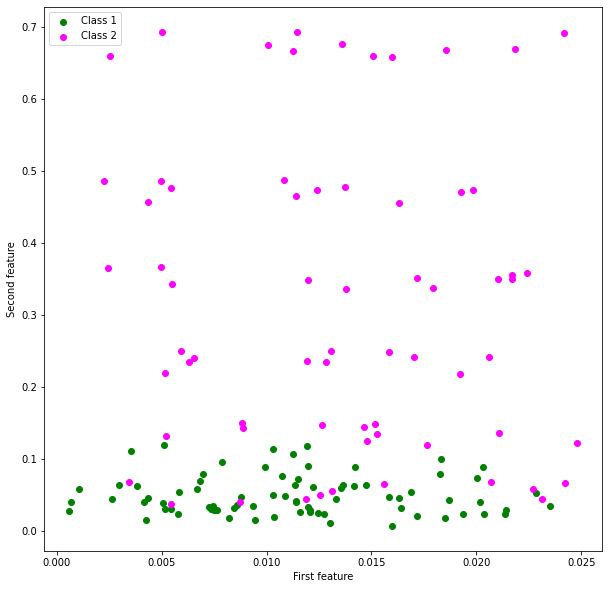

In [255]:
cechytestowe3 = treningowy3.loc[:, list_of_features]
cechytestowe5 = treningowy5.loc[:, list_of_features]
plt.figure()
plt.scatter(cechytestowe3[list_of_features[1]], cechytestowe3[list_of_features[2]], color = 'green', label='Class 1')
plt.scatter(cechytestowe5[list_of_features[1]], cechytestowe5[list_of_features[2]], color ='magenta', label='Class 2')
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.legend()
plt.show()

In [256]:
def edist(p1, p2, features):
    distance_elements = []
    for i in range(0, len(features)):
        distance_elements.append((p1[features[i]]-p2[features[i]])**2)
    distance = sum(distance_elements)**(1/2)
    return distance

In [257]:
testowy = testowy.loc[:, list_of_features]
testowy['Observed class'] = None
testowy.rename(columns={0:'Class'}, inplace=True)
treningowy = treningowy.loc[:, list_of_features]

k = 3 # number of neighbours

for i in range(len(testowy.iloc[:])):
    distancelist = []
    for j in range(len(treningowy.iloc[:])):
        distance = edist(testowy.values[i], treningowy.values[j], [1,2])
        distancelist.append((distance, treningowy.iloc[j,0]))
    distancelist = sorted(distancelist, key=lambda tup: tup[0])
    if k == 1:
        distancebest = distancelist[0]
    else:
        distancebest = distancelist[0:k-1]
    listofclasses = []
    for j in distancebest:
        listofclasses.append(j[1])
    classdominant = max(set(listofclasses), key=listofclasses.count)
    testowy.iloc[i, 3] = classdominant

testowy

,Class,9,14,Observed class
7,33.0,0.017562,0.331397,33.0
12,33.0,0.018170,0.282381,33.0
28,33.0,0.023952,0.770491,33.0
55,1.0,0.017157,0.026385,1.0
73,1.0,0.016886,0.023483,1.0
...,...,...,...,...
1448,33.0,0.032721,0.414050,33.0
1467,1.0,0.030183,0.027310,1.0
1473,33.0,0.039825,0.378383,33.0
1479,1.0,0.022431,0.054469,1.0


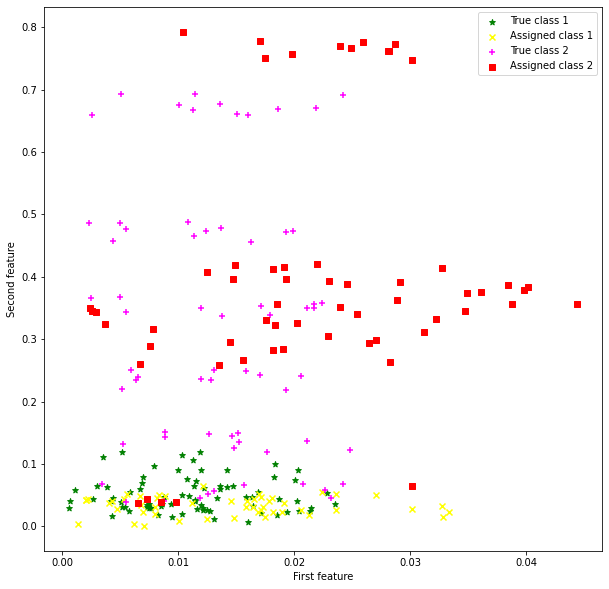

In [258]:
testowy3 = testowy[(testowy['Observed class'] == list_of_classes[0])]
testowy5 = testowy[(testowy['Observed class'] == list_of_classes[1])]
plt.rcParams["figure.figsize"] = (10, 10)
plt.figure()
plt.scatter(cechytestowe3[list_of_features[1]], cechytestowe3[list_of_features[2]], color = 'green', label='True class 1', marker='*')
plt.scatter(testowy3[list_of_features[1]], testowy3[list_of_features[2]], color='yellow', label='Assigned class 1', marker='x')
plt.scatter(cechytestowe5[list_of_features[1]], cechytestowe5[list_of_features[2]], color ='magenta', label='True class 2', marker='+')
plt.scatter(testowy5[list_of_features[1]], testowy5[list_of_features[2]], color='red', label='Assigned class 2', marker='s')
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.legend()
plt.show()

In [259]:
score = 0
for i in range(len(testowy.values)):
    if testowy.values[i][0] == testowy.values[i][3]:
        score += 1
print(f' Accuracy is {round(score/len(testowy.values), 3)}')

 Accuracy is 0.955


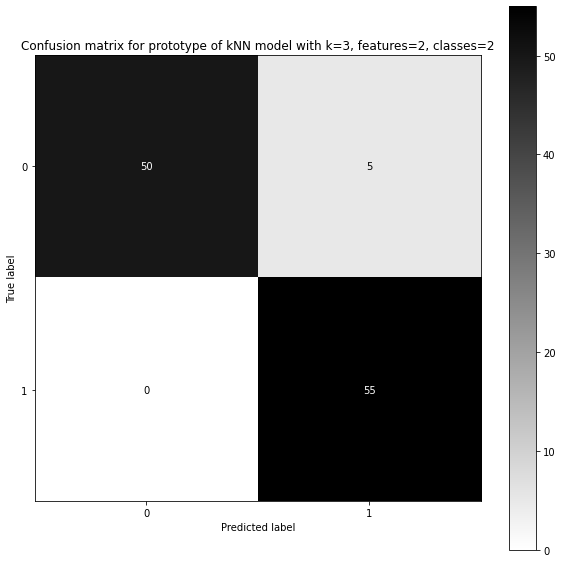

In [260]:
def cm(ytest, ypred, title, showplot=True):

    cm = confusion_matrix(ytest, ypred)
    # tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    #
    # sensitivity = tp/(tp+fn)
    # specificity = tn/(tn+fp)
    # balacc = (sensitivity+specificity)/2
    # f1score = 2*(sensitivity*specificity)/(specificity+sensitivity)

    if showplot:
        cm = ConfusionMatrixDisplay(confusion_matrix=cm)
        cm.plot(cmap='binary')
        plt.title(title)
        plt.show()


true_class = list(testowy.loc[:, 'Class'])
model_class = list(testowy.loc[:, 'Observed class'])

cm(true_class, model_class, 'Confusion matrix for prototype of kNN model with k=3, features=2, classes=2')

In [261]:
def model(list_of_classes, list_of_features, k):

    for i in range(len(list_of_classes)):
        if i == 0:
            treningowy = train[(train[0] == list_of_classes[0])]
            testowy = test[(test[0] == list_of_classes[0])]
        else:
            treningowy = pd.concat([treningowy, train[(train[0] == list_of_classes[i])]], axis=0)
            testowy = pd.concat([testowy, test[(test[0] == list_of_classes[i])]], axis=0)

    testowy = testowy.loc[:, list_of_features]
    testowy['Observed class'] = None
    testowy.rename(columns={0:'Class'}, inplace=True)
    treningowy = treningowy.loc[:, list_of_features]

    features = []
    for i in range(1, len(list_of_features)):
        features.append(i)

    for i in range(len(testowy.iloc[:])):
        distancelist = []
        for j in range(len(treningowy.iloc[:])):
            distance = edist(testowy.values[i], treningowy.values[j], features)
            distancelist.append((distance, treningowy.iloc[j,0]))
        distancelist = sorted(distancelist, key=lambda tup: tup[0])

        if k == 1:
            testowy.iloc[i, -1] = distancelist[0][1]

        else:
            distancebest = distancelist[0:k-1]
            listofclasses = []
            for j in distancebest:
                listofclasses.append(j[1])
            classdominant = max(set(listofclasses), key=listofclasses.count)
            testowy.iloc[i, -1] = classdominant

    true_class = list(testowy.loc[:, 'Class'])
    model_class = list(testowy.loc[:, 'Observed class'])
    return true_class, model_class


<h1><center><font size="6">Badanie wpływu wartości parametrów k, liczby klas i liczby cech na efektywność modelu</font></center></h1>

In [262]:
k = [1, 3, 5, 7]
set_2_2 = []
f1_2_2 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 3):
    list_of_classes.append(float(i))
for i in range(1, 3):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_2_2.append(prec)
    set_2_2.append(balacc)

In [263]:
set_2_5 = []
f1_2_5 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 3):
    list_of_classes.append(float(i))
for i in range(1, 6):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_2_5.append(prec)
    set_2_5.append(balacc)

In [264]:
set_2_10 = []
f1_2_10 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 3):
    list_of_classes.append(float(i))
for i in range(1, 11):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_2_10.append(prec)
    set_2_10.append(balacc)

In [265]:
set_4_2 = []
f1_4_2 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 5):
    list_of_classes.append(float(i))
for i in range(1, 3):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_4_2.append(prec)
    set_4_2.append(balacc)

In [266]:
set_4_5 = []
f1_4_5 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 5):
    list_of_classes.append(float(i))
for i in range(1, 6):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_4_5.append(prec)
    set_4_5.append(balacc)

In [267]:
set_4_10 = []
f1_4_10 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 5):
    list_of_classes.append(float(i))
for i in range(1, 11):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_4_10.append(prec)
    set_4_10.append(balacc)

In [268]:
set_8_2 = []
f1_8_2 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 9):
    list_of_classes.append(float(i))
for i in range(1, 3):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_8_2.append(prec)
    set_8_2.append(balacc)

In [269]:
set_8_5 = []
f1_8_5 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 9):
    list_of_classes.append(float(i))
for i in range(1, 6):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_8_5.append(prec)
    set_8_5.append(balacc)

In [270]:
set_8_10 = []
f1_8_10 = []
list_of_classes = []
list_of_features = [0]
for i in range(1, 9):
    list_of_classes.append(float(i))
for i in range(1, 11):
    list_of_features.append(int(i))
for i in k:
    true_class, model_class = model(list_of_classes, list_of_features, i)
    balacc = balanced_accuracy_score(true_class, model_class)
    prec = f1_score(true_class, model_class, average='micro')
    f1_8_10.append(prec)
    set_8_10.append(balacc)

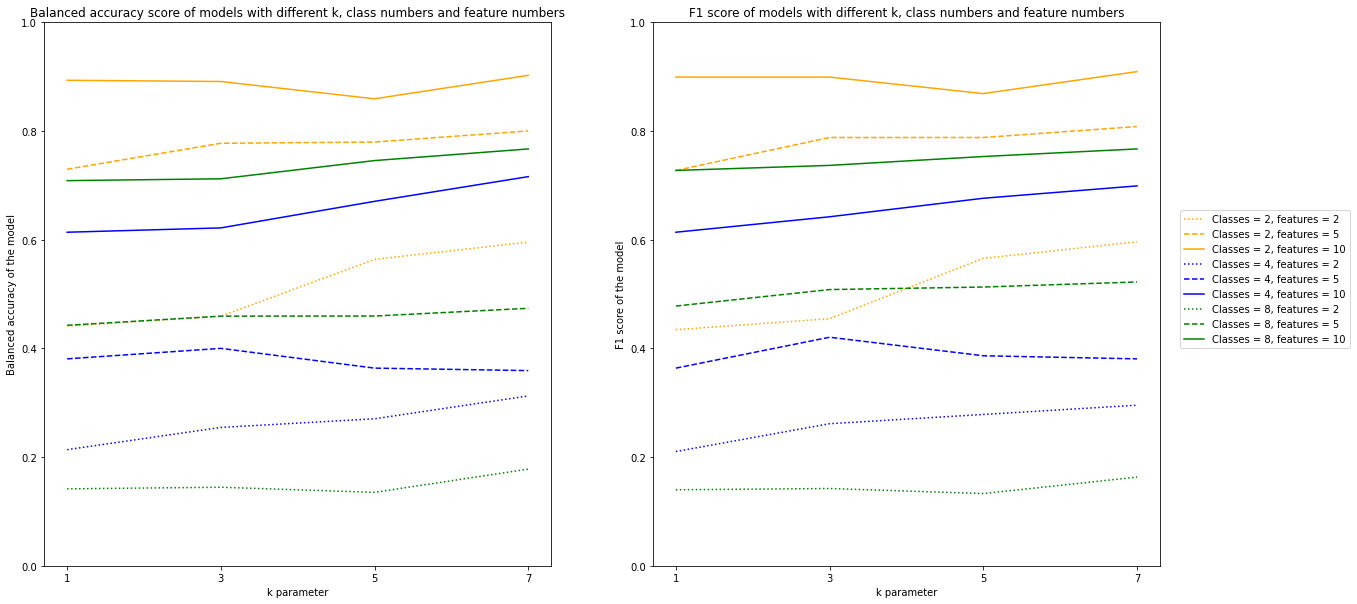

In [283]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(k, set_2_2, label = 'Classes = 2, features = 2', color = 'orange', ls = ':')
ax1.plot(k, set_2_5, label = 'Classes = 2, features = 5', color = 'orange', ls = '--')
ax1.plot(k, set_2_10, label = 'Classes = 2, features = 10', color = 'orange', ls = '-')

ax1.plot(k, set_4_2, label = 'Classes = 4, features = 2', color = 'blue', ls = ':')
ax1.plot(k, set_4_5, label = 'Classes = 4, features = 5', color = 'blue', ls = '--')
ax1.plot(k, set_4_10, label = 'Classes = 4, features = 10', color = 'blue', ls = '-')

ax1.plot(k, set_8_2, label = 'Classes = 8, features = 2', color = 'green', ls = ':')
ax1.plot(k, set_8_5, label = 'Classes = 8, features = 5', color = 'green', ls = '--')
ax1.plot(k, set_8_10, label = 'Classes = 8, features = 10', color = 'green', ls = '-')

ax1.set_xlabel('k parameter')
ax1.set_ylabel('Balanced accuracy of the model')
ax1.set_title('Balanced accuracy score of models with different k, class numbers and feature numbers')
ax1.set_xticks([1,3,5,7])
ax1.set_ylim(0,1)


ax2.plot(k, f1_2_2, label = 'Classes = 2, features = 2', color = 'orange', ls = ':')
ax2.plot(k, f1_2_5, label = 'Classes = 2, features = 5', color = 'orange', ls = '--')
ax2.plot(k, f1_2_10, label = 'Classes = 2, features = 10', color = 'orange', ls = '-')

ax2.plot(k, f1_4_2, label = 'Classes = 4, features = 2', color = 'blue', ls = ':')
ax2.plot(k, f1_4_5, label = 'Classes = 4, features = 5', color = 'blue', ls = '--')
ax2.plot(k, f1_4_10, label = 'Classes = 4, features = 10', color = 'blue', ls = '-')

ax2.plot(k, f1_8_2, label = 'Classes = 8, features = 2', color = 'green', ls = ':')
ax2.plot(k, f1_8_5, label = 'Classes = 8, features = 5', color = 'green', ls = '--')
ax2.plot(k, f1_8_10, label = 'Classes = 8, features = 10', color = 'green', ls = '-')

ax2.set_xlabel('k parameter')
ax2.set_ylabel('F1 score of the model')
ax2.set_title('F1 score of models with different k, class numbers and feature numbers')
ax2.set_xticks([1,3,5,7])
ax2.set_ylim(0,1)
ax2.legend(loc=(1.04,0.4))
plt.show()

<div style="text-align: justify">

Balanced accuracy score to metryka obliczana na podstawie czułości i specyficzności modelu, a więc nieco lepsza niż zwykłe accuracy. Najlepsza wartość tej metryki to 1, podczas gdy 0.5 to losowe wybranie klasy.
F1 score to metryka obliczana również na podstawie czułości i specyficzności modelu, ale w nieco inny sposób niż BAS. F1 score nie bierze pod uwagę próbek zaklasyfikowanych niepoprawnie, a BAS już tak.

Z podanego wyżej wykresu wynika jednoznacznie iż modele charakteryzują się dużo większym balanced accuracy score i F1 score, kiedy liczba cech rośnie. Jest to charakterystyczne dla każdej grupy modeli ze stałą liczbą klas (linia ciągła każdego koloru jest najwyżej spośród innych linii tego samego koloru). Jednocześnie największym balanced accuracy score i F1 score wykazał się model, gdzie liczba klas wynosiła 2, a liczba cech 10, ponieważ model ten dysponował bardzo dużą ilością danych, a miał mały wybór dostępnych klas - tylko dwie. Zwiększająca się wartość parametru k miała w większości modeli znikomy wpływ na poprawę wyników ich klasyfikacji - w niektórych score zwiększył się, a w niektórych zmniejszył, o nieznaczny procent wartości (poza modelem classes = 2, features = 2, gdzie zwiększenie parametru k spowodowało aż 10% wzrost poprawy BAS, co jest odstępstwem od normy. Warto też zauważyć podobieństwo kształtu krzywych na obydwu wykresach, jednak nie są one identyczne.

Różnica pomiędzy algorytmem NN, a kNN, gdzie algorytm NN jest wariantem algorytmu kNN z k = 1, na podstawie powyższego wykresu nie wydaje się być znacząca i nie poprawia jednoznacznie BAS modeli.

</div>